In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import mean, stddev, col, log
from pyspark.sql.functions import to_date, dayofweek, to_timestamp
from pyspark.sql import types 
from pyspark.sql.functions import col, udf
from datetime import datetime
from pyspark.sql.types import DateType
from pyspark.sql.functions import year, month
from pyspark.sql.functions import dayofmonth, weekofyear
from pyspark.sql.functions import split, explode
from pyspark.sql.functions import coalesce, first, lit
from pyspark.ml.feature import Binarizer
from pyspark.ml.feature import Bucketizer
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.sql.functions import regexp_extract, col

In [3]:
from modules.pyspark import CPySpark
from pyspark.sql import Row, SQLContext

In [4]:
spark = CPySpark(session=True, sql=True)

In [5]:
spark = spark.session

In [6]:
df = spark.read.csv("./data/2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)

df_sub = df.select('STREETNUMBERNUMERIC', 'FIREPLACES', 
                   'LOTSIZEDIMENSIONS', 'LISTTYPE', 'ACRES', 
                   'ASSUMABLEMORTGAGE', 'SalesClosePrice', 'ListPrice',
                   'DAYSONMARKET')
df_sub.show(5)

+-------------------+----------+-----------------+---------------+-----+-----------------+---------------+---------+------------+
|STREETNUMBERNUMERIC|FIREPLACES|LOTSIZEDIMENSIONS|       LISTTYPE|ACRES|ASSUMABLEMORTGAGE|SalesClosePrice|ListPrice|DAYSONMARKET|
+-------------------+----------+-----------------+---------------+-----+-----------------+---------------+---------+------------+
|              11511|         0|          279X200|Exclusive Right| 1.28|             null|         143000|   139900|          10|
|              11200|         0|          100x140|Exclusive Right| 0.32|             null|         190000|   210000|           4|
|               8583|         0|          120x296|Exclusive Right|0.822|    Not Assumable|         225000|   225000|          28|
|               9350|         1|          208X208|Exclusive Right| 0.94|             null|         265000|   230000|          19|
|               2915|         1|          116x200|Exclusive Right|  0.0|             null|

In [7]:
df_sub = df_sub.drop(*['STREETNUMBERNUMERIC', 'LOTSIZEDIMENSIONS'])
df_sub.show(5)

+----------+---------------+-----+-----------------+---------------+---------+------------+
|FIREPLACES|       LISTTYPE|ACRES|ASSUMABLEMORTGAGE|SalesClosePrice|ListPrice|DAYSONMARKET|
+----------+---------------+-----+-----------------+---------------+---------+------------+
|         0|Exclusive Right| 1.28|             null|         143000|   139900|          10|
|         0|Exclusive Right| 0.32|             null|         190000|   210000|           4|
|         0|Exclusive Right|0.822|    Not Assumable|         225000|   225000|          28|
|         1|Exclusive Right| 0.94|             null|         265000|   230000|          19|
|         1|Exclusive Right|  0.0|             null|         249900|   239900|          21|
+----------+---------------+-----+-----------------+---------------+---------+------------+
only showing top 5 rows



In [8]:
df_sub.select(['ASSUMABLEMORTGAGE']).distinct().show()

+-------------------+
|  ASSUMABLEMORTGAGE|
+-------------------+
|  Yes w/ Qualifying|
| Information Coming|
|               null|
|Yes w/No Qualifying|
|      Not Assumable|
+-------------------+



In [9]:
df_sub.count()

5000

In [10]:
yes_values = ['Yes w/ Qualifying', 'Yes w/No Qualifying']

In [11]:
text_filter = ~df_sub['ASSUMABLEMORTGAGE'].isin(yes_values) | df_sub['ASSUMABLEMORTGAGE'].isNull()
df_sub = df.where(text_filter) 

In [12]:
df_sub.count()

4976

/home/manhcuong/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

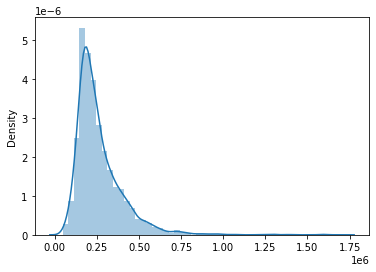

In [19]:
df_scp = df_sub.select('SalesClosePrice').toPandas()
sns.distplot(df_scp)

In [20]:
df_sub = df_sub.withColumn('log_ScalesClosePrice', log(col('SalesClosePrice')))

In [21]:
df_sub.count()

4976

In [29]:
df_sub

DataFrame[No: int, MLSID: string, StreetNumberNumeric: int, streetaddress: string, STREETNAME: string, PostalCode: int, StateOrProvince: string, City: string, SalesClosePrice: int, LISTDATE: string, LISTPRICE: int, LISTTYPE: string, OriginalListPrice: int, PricePerTSFT: double, FOUNDATIONSIZE: int, FENCE: string, MapLetter: string, LotSizeDimensions: string, SchoolDistrictNumber: string, DAYSONMARKET: int, offmarketdate: string, Fireplaces: int, RoomArea4: string, roomtype: string, ROOF: string, RoomFloor4: string, PotentialShortSale: string, PoolDescription: string, PDOM: int, GarageDescription: string, SQFTABOVEGROUND: int, Taxes: int, RoomFloor1: string, RoomArea1: string, TAXWITHASSESSMENTS: double, TAXYEAR: int, LivingArea: int, UNITNUMBER: string, YEARBUILT: int, ZONING: string, STYLE: string, ACRES: double, CoolingDescription: string, APPLIANCES: string, backonmarketdate: string, ROOMFAMILYCHAR: string, RoomArea3: string, EXTERIOR: string, RoomFloor3: string, RoomFloor2: string,

In [30]:
df_sub.select('log_ScalesClosePrice').toPandas()

,log_ScalesClosePrice
0,11.870600
1,12.154779
2,12.323856
3,12.487485
4,12.428816
...,...
4971,13.591116
4972,13.598598
4973,13.670485
4974,13.864506


/home/manhcuong/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

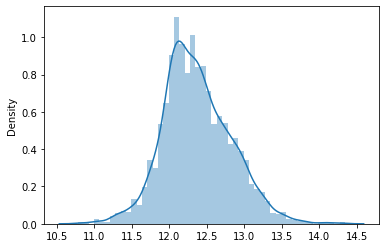

In [31]:
sns.distplot(df_sub.select('log_ScalesClosePrice').toPandas())

In [32]:
mean_val = df_sub.agg({'log_ScalesClosePrice': 'mean'}).collect()[0][0]

In [33]:
stddev_val = df_sub.agg({'log_ScalesClosePrice': 'stddev'}).collect()[0][0]

In [34]:
low_bound = mean_val - (3 * stddev_val)
upper_bound = mean_val + (3 * stddev_val)

In [35]:
df_sub = df_sub.where((df_sub['log_ScalesClosePrice'] < upper_bound) & (df_sub['log_ScalesClosePrice'] > low_bound))

In [36]:
df_sub.count()

4946

In [38]:
df_sub.select('log_ScalesClosePrice').toPandas()

,log_ScalesClosePrice
0,11.870600
1,12.154779
2,12.323856
3,12.487485
4,12.428816
...,...
4941,13.586097
4942,13.567049
4943,13.591116
4944,13.598598


/home/manhcuong/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

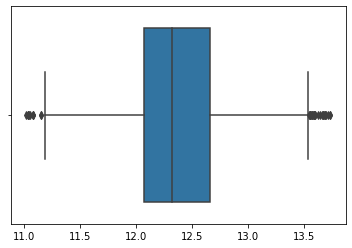

In [43]:
sns.boxplot(df_sub.select('log_ScalesClosePrice').toPandas().values)

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().